In [1]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [26]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
#import easydict
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

Make train data use 50persent of "bird", "deer", "truck"

In [27]:
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True)

train_imgs = []
train_labels = []
test_imgs = []
test_labels = []

count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #for confirm
_50_persent_img_list = [2, 4, 9] #bird, deer, truck

for images, labels in trainset:
    if labels in _50_persent_img_list:
        if (count[labels] < 2500):
            train_imgs.append(images)
            train_labels.append(labels)
            count[labels]+=1
    elif labels == 0:
        if (count[labels] < 4996):
            train_imgs.append(images)
            train_labels.append(labels)
            count[labels]+=1     
    else:
        train_imgs.append(images)
        train_labels.append(labels)            
        count[labels]+=1

print("count", count)
    
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True)
for images, labels in testset:
    test_imgs.append(images)
    test_labels.append(labels)

Files already downloaded and verified
count [4996, 5000, 2500, 5000, 2500, 5000, 5000, 5000, 5000, 2500]
Files already downloaded and verified


In [28]:
class My_datasets(torch.utils.data.Dataset):
    def __init__(self, data, label, train = 'True', mode = 'AutoEncoder'):
        self.data = data
        self.label = label
        self.datanum = len(self.data)
        self.train = train
        if mode == 'AutoEncoder':
            self.transform_train = transforms.Compose([#transforms.RandomCrop(32, padding=4),
                                 #transforms.RandomHorizontalFlip(),
                                 #transforms.RandomVerticalFlip(),
                                 #transforms.RandomRotation(degrees=30),
                                 transforms.ToTensor(),
                                 transforms.Normalize(
                                    [0.5, 0.5, 0.5],  # RGB 平均
                                    [0.5, 0.5, 0.5]   # RGB 標準偏差
                                    )])
        else:
            self.transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                 transforms.RandomHorizontalFlip(),
                                 #transforms.RandomVerticalFlip(),
                                 transforms.RandomRotation(degrees=30),
                                 transforms.ToTensor(),
                                 transforms.Normalize(
                                    [0.5, 0.5, 0.5],  # RGB 平均
                                    [0.5, 0.5, 0.5]   # RGB 標準偏差
                                    )])            
        
        self.transform_test = transforms.Compose([  
                                transforms.ToTensor(),
                                transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]  # RGB 標準偏差
                                )])
        
        
    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_data = self.data[idx]
        if self.train == "True":
            out_data = self.transform_train(out_data)        
        else:
            out_data = self.transform_test(out_data)
            
        out_label = torch.tensor(self.label[idx])
        
        return out_data, out_label

transform_data=transforms.Compose([transforms.RandomCrop(32, padding=4),
                             transforms.RandomHorizontalFlip(),
                             #transforms.RandomVerticalFlip(),
                             transforms.RandomRotation(degrees=30),
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )])


train_dataset = My_datasets(train_imgs, train_labels, train='True')
test_dataset = My_datasets(test_imgs, test_labels, train='False')
#print(len(train_dataset), len(test_dataset))
my_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
my_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

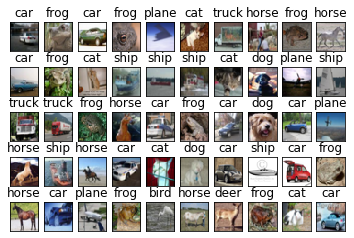

In [29]:
if __name__ == '__main__':
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    for images, labels in my_trainloader:
        for i in range(5):
            for j in range(10):
                image = images[i*10+j] / 2 + 0.5
                image = image.numpy()
                plt.subplot(5, 10, i*10+j + 1)
                plt.imshow(np.transpose(image, (1, 2, 0)))
                plt.title(classes[int(labels[i*10+j])])
                plt.tick_params(labelbottom=False,
                                labelleft=False,
                                labelright=False,
                                labeltop=False,
                                bottom=False,
                                left=False,
                                right=False,
                                top=False)
 
        plt.show()
        break

Make test loader()

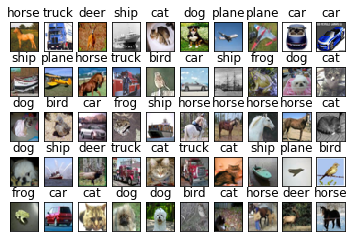

In [32]:
if __name__ == '__main__':
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    for images, labels in my_testloader:
        for i in range(5):
            for j in range(10):
                image = images[i*10+j] / 2 + 0.5
                image = image.numpy()
                plt.subplot(5, 10, i*10+j + 1)
                plt.imshow(np.transpose(image, (1, 2, 0)))
                plt.title(classes[int(labels[i*10+j])])
                plt.tick_params(labelbottom=False,
                                labelleft=False,
                                labelright=False,
                                labeltop=False,
                                bottom=False,
                                left=False,
                                right=False,
                                top=False)
 
        plt.show()
        break

Model

In [7]:
class resblock(nn.Module):
    def __init__(self, ch, nblocks=1, shortcut=True):
        super().__init__()
        self.shortcut = shortcut
        self.module_list = nn.ModuleList()
        for i in range(nblocks):
            resblock_one = nn.ModuleList()
            resblock_one.append(Conv_Bn_Activation(ch, ch//2, kernel_size=1, stride=1, activation = 'leaky'))
            resblock_one.append(Conv_Bn_Activation(ch//2, ch, kernel_size=3, stride=1, activation = 'leaky'))
            self.module_list.append(resblock_one)  
            
    def forward(self,x):
        for module in self.module_list:
            h = x
            for res in module:
                h = res(h)
            x = x + h if self.shortcut else h          
        return x


class Conv_Bn_Activation(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, activation, conv = "Conv2d", dilation=1, pool=1, bn=True, bias=False, UpSample=1):
        super().__init__()
        self.conv = nn.ModuleList()
        pad = (kernel_size - 1) // 2
        
        if UpSample != 1:
            self.conv.append(nn.Upsample(scale_factor=UpSample, mode = 'nearest'))        
        if conv == "Conv2d":
            if bias:
                self.conv.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, dilation))
            else:
                self.conv.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, dilation, bias=False))                                
        if bn:
            self.conv.append(nn.BatchNorm2d(out_channels, track_running_stats=False))            
        if activation == "tanh":
            self.conv.append(nn.Tanh())
        elif activation == "sigmoid":
            self.conv.append(nn.Sigmoid())
        elif activation == "mish":
            self.conv.append(Mish())
        elif activation == "relu":
            self.conv.append(nn.ReLU(inplace=True))
        elif activation == "leaky":
            #self.conv.append(nn.LeakyReLU(0.1, inplace=True))
            self.conv.append(nn.LeakyReLU(0.1))
        elif activation == "linear":
            pass
        else:
            print("activate error !!!")
        if pool != 1:
            self.conv.append(nn.MaxPool2d(pool, pool))

    def forward(self, x):
        for l in self.conv:
            x = l(x)
        return x
    
def enc_modules():
    module_list = nn.ModuleList()
    module_list.append(Conv_Bn_Activation(3, 32, kernel_size = 3, stride = 1, activation = 'leaky')) #32, 32, 32
    module_list.append(Conv_Bn_Activation(32, 64, kernel_size = 3, stride = 2, activation = 'leaky')) #64, 16, 16
    module_list.append(resblock(ch=64)) #64, 16, 16
    module_list.append(Conv_Bn_Activation(64, 128, kernel_size = 3, stride = 2, activation = 'leaky')) #128, 8, 8
    module_list.append(resblock(ch=128, nblocks=2)) #128, 8, 8
    
    return module_list

def dec_modules():
    module_list = nn.ModuleList()    
    module_list.append(resblock(ch=128, nblocks=2)) #128, 8, 8
    module_list.append(Conv_Bn_Activation(128, 64, kernel_size=3, stride=1, UpSample=2, activation = 'leaky')) #64, 16, 16
    module_list.append(resblock(ch=64)) #64, 16, 16
    module_list.append(Conv_Bn_Activation(64, 32, kernel_size=3, stride=1, UpSample=2, activation = 'leaky')) #32, 32, 32
    module_list.append(Conv_Bn_Activation(32, 3, kernel_size=3, stride=1, activation = 'leaky')) #32, 32, 32   
    
    return module_list

def det_modules():
    module_list = nn.ModuleList()
    module_list.append(Conv_Bn_Activation(128, 256, kernel_size=3, stride=2, activation = 'leaky')) #256, 4, 4
    module_list.append(resblock(ch=256, nblocks=8))    #256, 4, 4
    module_list.append(Conv_Bn_Activation(256, 512, kernel_size=3, stride=2, activation = 'leaky')) #512, 2, 2
    module_list.append(resblock(ch=512, nblocks=8))    #512, 2, 2
    module_list.append(Conv_Bn_Activation(512, 1024, kernel_size=3, stride=2, activation = 'leaky'))#1024, 1, 1
    module_list.append(resblock(ch=1024, nblocks=4))#1024, 1, 1
    module_list.append(Conv_Bn_Activation(1024, 10, kernel_size=1, stride=1, activation = 'leaky'))#10, 1, 1
    
    return module_list

class AutoEncoder(torch.nn.Module):
    def __init__(self, mode = "AutoEncoder"):
        super().__init__()
        self.enc = enc_modules()
        self.mode = mode
        if self.mode == "AutoEncoder":
            self.dec = dec_modules()
        else:
            self.det = det_modules()
        
    def forward(self, x):
        #enc module forward
        for layer, module in enumerate(self.enc):
            x = module(x)
        enc = x
        
        #dec module forward
        if self.mode == "AutoEncoder":
            for module in self.dec:
                x = module(x)
            dec = x 
            return enc,dec
        
        #det module forward
        else:
            for module in self.det:
                x = module(x)
            det = x.reshape(-1, 10)
            return enc, det

In [8]:
num_epochs = 150

net = AutoEncoder()
classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

def burnin_schedule(epoch):
    if i < 10:
        return 1.0
    elif i < 50:
        return 0.2
    elif i < 100:
        return 0.02
    else:
        return 0.01

net = AutoEncoder().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), momentum = 0.9, lr=0.05)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = burnin_schedule)
"""
load_path = './log/darknet/AutoEncoder_weights_tuning.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)
"""
output_and_label = []

def train(train_loader):
    net.train()
    running_loss = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        enc_output, dec_output = net(images)
        loss = criterion(dec_output, images)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
        
    output_and_label.append((enc_output, dec_output, images, labels))
    train_loss = running_loss / len(train_loader)

    return train_loss

def valid(test_loader):
    net.eval()
    running_loss = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            enc_output, dec_output = net(images)
            loss = criterion(dec_output, images)
            running_loss += loss.item()            

        output_and_label.append((enc_output, dec_output, images, labels))
    val_loss = running_loss / len(test_loader)

    return val_loss

loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    output_and_label.clear()
    loss = train(my_trainloader)
    val_loss = valid(my_testloader)
    print('epoch %d, loss: %.4f val_loss: %.4f' % (epoch, loss, val_loss))

    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)

print('Finished training')
#save the trained model
save_path = './log/darknet/AutoEncoder_weights_tuning.pth'
torch.save(net.state_dict(), save_path)

#save loss_list
np.save('./log/darknet/autoencoder_loss_list.npy', np.array(loss_list))
np.save('./log/darknet/autoencoder_val_loss_list.npy', np.array(val_loss_list))

使用デバイス： cuda:0


/home/sen/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch 0, loss: 0.1163 val_loss: 0.0709
epoch 1, loss: 0.0538 val_loss: 0.0383
epoch 2, loss: 0.0331 val_loss: 0.0273
epoch 3, loss: 0.0243 val_loss: 0.0208
epoch 4, loss: 0.0200 val_loss: 0.0186
epoch 5, loss: 0.0178 val_loss: 0.0173
epoch 6, loss: 0.0167 val_loss: 0.0162
epoch 7, loss: 0.0157 val_loss: 0.0147
epoch 8, loss: 0.0146 val_loss: 0.0148
epoch 9, loss: 0.0137 val_loss: 0.0152
epoch 10, loss: 0.0132 val_loss: 0.0125
epoch 11, loss: 0.0127 val_loss: 0.0121
epoch 12, loss: 0.0119 val_loss: 0.0116
epoch 13, loss: 0.0114 val_loss: 0.0111
epoch 14, loss: 0.0109 val_loss: 0.0112
epoch 15, loss: 0.0108 val_loss: 0.0102
epoch 16, loss: 0.0105 val_loss: 0.0104
epoch 17, loss: 0.0099 val_loss: 0.0101
epoch 18, loss: 0.0100 val_loss: 0.0106
epoch 19, loss: 0.0096 val_loss: 0.0096
epoch 20, loss: 0.0096 val_loss: 0.0097
epoch 21, loss: 0.0093 val_loss: 0.0103
epoch 22, loss: 0.0090 val_loss: 0.0087
epoch 23, loss: 0.0089 val_loss: 0.0097
epoch 24, loss: 0.0088 val_loss: 0.0086
epoch 25, 

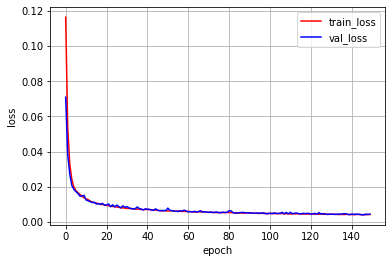

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# plot learning curve
loss_list = np.load('./log/darknet/autoencoder_loss_list.npy')
val_loss_list = np.load('./log/darknet/autoencoder_val_loss_list.npy')

plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

Test image after autoencoder

output_and_label <class 'torch.Tensor'> 2 4
org torch.Size([16, 3, 32, 32])
torch.Size([6, 3, 32, 32])
img <class 'torch.Tensor'> torch.Size([6, 3, 32, 32])


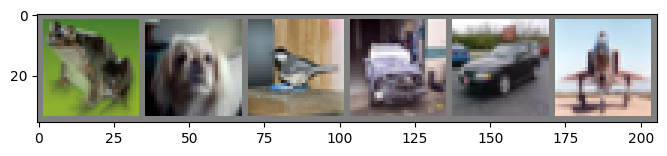

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img <class 'torch.Tensor'> torch.Size([6, 3, 32, 32])


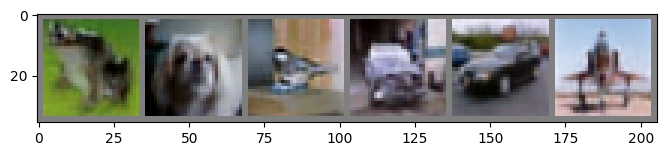

In [11]:
def imshow(img):
    print("img", type(img), img.shape)
    img = torchvision.utils.make_grid(img)
    img = img / 2 + 0.5
    fig = plt.figure(dpi=100, figsize=(8,4))
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print("output_and_label", type(output_and_label[0][0]), len(output_and_label),len(output_and_label[0]))
enc_output, output, org, label = output_and_label[1]
print("org", org.shape)
org = org[0:6]
output = output[0:6]
org = org.cpu()
output = output.cpu()
print(output.shape)
imshow(org)
imshow(output)

Detect (before train, change transform)

In [12]:
train_dataset = My_datasets(train_imgs, train_labels, train='True', mode='Detect')
test_dataset = My_datasets(test_imgs, test_labels, train='False')
my_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
my_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

Confirm transform

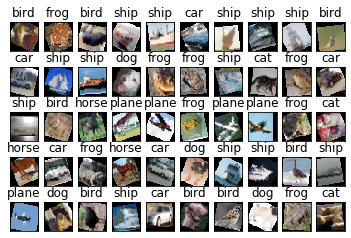

In [13]:
if __name__ == '__main__':
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')  # CIFAR10のクラス
    for images, labels in my_trainloader:
        for i in range(5):
            for j in range(10):
                image = images[i*10+j] / 2 + 0.5
                image = image.numpy()
                plt.subplot(5, 10, i*10+j + 1)
                plt.imshow(np.transpose(image, (1, 2, 0)))  # matplotlibではチャネルは第3次元
                
                # 対応するラベル
                plt.title(classes[int(labels[i*10+j])])
                
                # 軸目盛や値はいらないので消す
                plt.tick_params(labelbottom=False,
                                labelleft=False,
                                labelright=False,
                                labeltop=False,
                                bottom=False,
                                left=False,
                                right=False,
                                top=False)
 
        plt.show()
        break

In [14]:
num_epochs = 100
    
classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

net = AutoEncoder(mode = "Detector").to(device)

def burnin_schedule(epoch):
    if i < 10:
        return 1.0
    elif i < 50:
        return 0.1
    elif i < 100:
        return 0.05
    else:
        return 0.01

criterion = torch.nn.CrossEntropyLoss()  # ロスの計算
optimizer = torch.optim.SGD(net.parameters(), momentum = 0.9, lr=0.01)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = burnin_schedule)

#load_path = './log/darknet/Detect_weights_tuning.pth'
#pretrained_dict = torch.load(load_path)
#net_dict = net.state_dict()

load_path = './log/darknet/AutoEncoder_weights_tuning.pth'
pretrained_dict = torch.load(load_path)
net_dict = net.state_dict()

for name, param in net.named_parameters():
    if "enc" in name:
        param.requires_grad = False
        

pretrained_dict = {k: v for k, v in pretrained_dict.items() if
                       (k in net_dict) and (net_dict[k].shape == pretrained_dict[k].shape)}
net_dict.update(pretrained_dict)
net.load_state_dict(net_dict)

#confirm requires_grad
#for name, param in net.named_parameters():
#    print(name, param.requires_grad)
    
output_and_label = []

def train(train_loader):
    net.train()
    running_loss = 0
    train_acc = 0
    train_total = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        enc_output, det_output = net(images)
        loss = criterion(det_output, labels.to(device))
        running_loss += loss.item()
        train_total += labels.size(0)
        train_acc += (det_output.max(1)[1] == labels.to(device)).sum().item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    output_and_label.append((enc_output, det_output, images, labels))
    train_loss = running_loss / len(my_trainloader)
    train_acc = train_acc / train_total
    
    return train_loss, train_acc
    
def valid(test_loader):
    net.eval()
    running_loss = 0
    val_acc = 0
    correct = 0
    val_total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            enc_output, det_output = net(images)
            loss = criterion(det_output, labels.to(device))
            running_loss += loss.item()            
            val_total += labels.size(0)
            val_acc += (det_output.max(1)[1] == labels.to(device)).sum().item()
        output_and_label.append((enc_output, det_output, images, labels))
    val_loss = running_loss / len(test_loader)
    val_acc = val_acc / val_total

    return val_loss, val_acc

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    output_and_label.clear()
    train_loss, train_acc = train(my_trainloader)
    val_loss, val_acc = valid(my_testloader)
    
    print('epoch %d, loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, train_loss, train_acc, val_loss, val_acc))

    # logging
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
print('Finished training')
save_path = './log/darknet/Detect_weights_tuning.pth'
torch.save(net.state_dict(), save_path)

# save the trained model
np.save('./log/darknet/Detect_train_loss_list.npy', np.array(train_loss_list))
np.save('./log/darknet/Detect_train_acc_list.npy', np.array(train_acc_list))
np.save('./log/darknet/Detect_val_loss_list.npy', np.array(val_loss_list))
np.save('./log/darknet/Detect_val_acc_list.npy', np.array(val_acc_list))

使用デバイス： cuda:0
epoch 0, loss: 1.8446 acc: 0.3705 val_loss: 1.6362 val_acc: 0.4406
epoch 1, loss: 1.5412 acc: 0.4731 val_loss: 1.5178 val_acc: 0.4729
epoch 2, loss: 1.4132 acc: 0.5129 val_loss: 1.3943 val_acc: 0.5079
epoch 3, loss: 1.3305 acc: 0.5389 val_loss: 1.3688 val_acc: 0.5202
epoch 4, loss: 1.2659 acc: 0.5592 val_loss: 1.3130 val_acc: 0.5396
epoch 5, loss: 1.2178 acc: 0.5752 val_loss: 1.2634 val_acc: 0.5533
epoch 6, loss: 1.1809 acc: 0.5870 val_loss: 1.2406 val_acc: 0.5627
epoch 7, loss: 1.1393 acc: 0.6041 val_loss: 1.2252 val_acc: 0.5715
epoch 8, loss: 1.1143 acc: 0.6101 val_loss: 1.2381 val_acc: 0.5744
epoch 9, loss: 1.0819 acc: 0.6212 val_loss: 1.1694 val_acc: 0.5899
epoch 10, loss: 1.0557 acc: 0.6298 val_loss: 1.1747 val_acc: 0.5878
epoch 11, loss: 1.0373 acc: 0.6346 val_loss: 1.1989 val_acc: 0.5900
epoch 12, loss: 1.0161 acc: 0.6454 val_loss: 1.1267 val_acc: 0.6102
epoch 13, loss: 0.9927 acc: 0.6535 val_loss: 1.1400 val_acc: 0.6080
epoch 14, loss: 0.9810 acc: 0.6566 val_loss

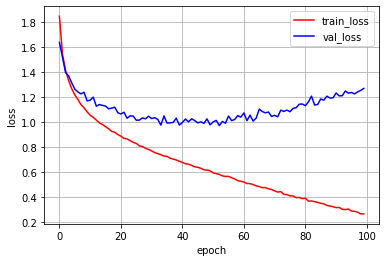

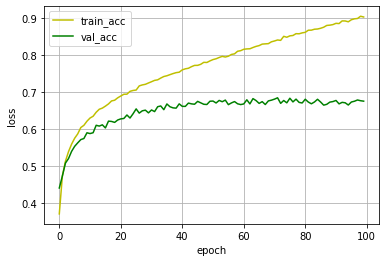

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
    
num_epochs = 100

# plot learning curve
plt.figure()
train_loss_list = np.load('./log/darknet/Detect_train_loss_list.npy')
val_loss_list = np.load('./log/darknet/Detect_val_loss_list.npy')
plt.plot(range(num_epochs), train_loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
train_acc_list = np.load('./log/darknet/Detect_train_acc_list.npy')
val_acc_list = np.load('./log/darknet/Detect_val_acc_list.npy')
plt.plot(range(num_epochs), train_acc_list, 'y-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

Graphical accuracy of each class

使用デバイス： cuda:0


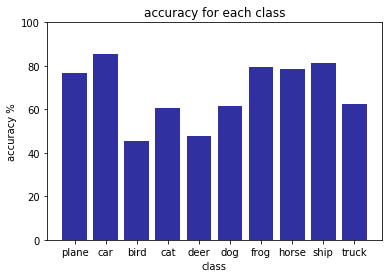

In [24]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

my_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=True)

net = AutoEncoder(mode = "Detector").to(device)

load_path = './log/darknet/Detect_weights_tuning.pth'
pretrained_dict = torch.load(load_path)
net_dict = net.state_dict()
net.load_state_dict(pretrained_dict)

acc_count = [0]*10

def valid(test_loader):
    net.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            enc_output, det_output = net(images)
            for i in range(10):
                index = np.where(labels.to('cpu').numpy() == i)
                acc_count[i] += (det_output[index].max(1)[1] == labels[index].to(device)).sum().item()/1000*100
                #all_output[i] = det_output[index].max(1)[1]
        
    #plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(classes, acc_count, color = '#3030A0')
    ax.set_ylim(0, 100)
    ax.set_xlabel('class')
    ax.set_ylabel('accuracy %')
    ax.set_title('accuracy for each class')
    plt.show
        
for epoch in range(1):
    output_and_label.clear()
    valid(my_testloader)